In [1]:
import numpy as np
from scipy.stats import wishart, poisson, norm, multivariate_normal

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
%matplotlib inline

import corner

In [2]:
from functions import * 

In [3]:
params = {'font.family': 'DejaVu Serif',
          'legend.fontsize': 'large',
          'axes.labelsize': 'large',
          'axes.titlesize':'large',
          'xtick.labelsize':'large',
          'xtick.direction':'in',
          'ytick.direction':'in',
          'ytick.labelsize':'large','font.size':19}
plt.rcParams.update(params)
inches_to_cm = 2.54
figsize = (40/inches_to_cm, 13/inches_to_cm)
dpi = 180

### Define Model

In [4]:
maxx = 20
ndim = 7
mu1 = np.random.uniform(-2.0, -1.0, ndim)
mu2 = np.random.uniform(1.0, 2.0, ndim)

cov1 = np.diag(np.random.uniform(1., 1.5, ndim))
cov1 = wishart.rvs(df=ndim * 8, scale=cov1 / ndim / 8)

cov2 = np.diag(np.random.uniform(1., 1.5, ndim))
cov2 = wishart.rvs(df=ndim * 4, scale=cov2 / ndim / 4)

f = np.random.uniform(1, 3, 2)
f /= np.sum(f)

def log_prob(x):
    lp1 = multivariate_normal.logpdf(x, mean=mu1, cov=cov1)
    lp2 = multivariate_normal.logpdf(x, mean=mu2, cov=cov2)
    
    pdf = np.logaddexp(lp1 + np.log(f[0]), lp2 + np.log(f[1]))
    return pdf

true = []
mu = [mu1, mu2]
cov = [cov1, cov2]
for ii in range(2):
    true.append(multivariate_normal.rvs(size = int(1000000 * f[ii]), mean=mu[ii], cov=cov[ii]))
true = np.vstack(true)

### Sample Using Varaha

In [5]:
# User provided
xrange = np.vstack([[-maxx, maxx]  for ii in range(ndim)]) #Start with a large rectangular bin same as dynesty.
xbox = np.array([[0, 1]] * ndim)#Start with a box.
#Sampler
dx, binunique, nbins, ninbin, lkl_thr, log_V, log_deltaV = {}, {}, {}, {}, {}, {}, {}
allx, allloglkl = np.transpose([[]] * ndim), []
cycle = lkl_cycle = probmass_cycle = 1
dx[cycle] = np.diff(xbox, axis = 1).flatten()
binunique[cycle] = np.array([ndim * [0]]) #There is only one unique bin in the beginning
nbins[cycle] = np.ones(ndim)
allx_log_injd = []
log_V[lkl_cycle] = 0
log_deltaV[lkl_cycle] = -np.inf
lkl_thr[lkl_cycle] = -np.inf
pinside = 1.0
perc_acc = 0.95
ti = 0
sampidx = []
del_upto_lkl = {}
del_upto_lkl[cycle] = -np.inf
nback = int(-np.log(2.0)/np.log(perc_acc))

max_injneff = 10000
nsel = 2000
nmc = int(max_injneff/perc_acc) + 1
# The number of samples in each unique bin. There is only one so all samples go there
ninbin[cycle] = [nmc]

while pinside > 0.05:
    
    x = sample_from_bins(xbox, dx[cycle], binunique[cycle], ninbin[cycle])
    xprior = xrange.T[0] + x * np.diff(xrange).flatten()#map back to original prior
    log_lkl = log_prob(xprior)
    ti += x.shape[0]

    idx = np.where(log_lkl >= lkl_thr[probmass_cycle])
    x = x[idx]
    log_lkl = log_lkl[idx]

    if cycle > 1:
        idx = np.where(allloglkl >= lkl_thr[probmass_cycle])
        allx = allx[idx]
        allloglkl = allloglkl[idx]
        allx_log_injd = allx_log_injd[idx]
        sampidx = sampidx[idx]

    allx_log_injd, log_injd_x = \
                update_injection_density(allx, x, allx_log_injd, xbox, dx, binunique, ninbin, cycle, 5)

    allx = np.append(allx, x, axis = 0)
    allloglkl = np.append(allloglkl, log_lkl)
    allx_log_injd = np.append(allx_log_injd, log_injd_x)
    sampidx = np.append(sampidx, cycle * np.ones_like(log_lkl))
    eff = len(log_lkl[log_lkl >= lkl_thr[lkl_cycle]]) / np.sum(ninbin[cycle])

    idx = np.where(allloglkl >= lkl_thr[lkl_cycle])
    log_injw = -allx_log_injd[idx]
    injw = np.exp(log_injw - log_injw.max())
    injneff = injw.sum() ** 2 / (injw**2).sum()

    next_lkl_thr = get_likelihood_threshold(allloglkl[idx], injw, perc_acc)
    sum1 = injw.sum()

    if sum1 > nsel and injneff > max_injneff:
        lkl_cycle += 1
        lkl_thr[lkl_cycle] = next_lkl_thr
        log_V[lkl_cycle], log_deltaV[lkl_cycle], _ = \
                volume_at_threshold(injw, allloglkl[idx], next_lkl_thr, log_V[lkl_cycle - 1], -np.inf, True)
        log_deltaV[lkl_cycle] = log_V[lkl_cycle] - 0.5 * np.log(injneff)

    del_upto_lkl[cycle] = lkl_thr[lkl_cycle]
    if probmass_cycle > 5 * nback:
        dx, binunique, ninbin, ninbin, allx_log_injd, allx, allloglkl, sampidx = \
            remove_early_cycles(allx_log_injd,allx,allloglkl,sampidx,xbox,dx,binunique,ninbin,del_upto_lkl, lkl_thr[probmass_cycle - 5 * nback], 5)
            
    lw  = allloglkl - allx_log_injd
    w = np.exp(lw - lw.max())
    neff_varaha = rnd(w.sum() ** 2 / (w**2).sum(), 1)
    nred = w.sum()/w.max()
    pinside = w[allloglkl > lkl_thr[lkl_cycle]].sum() / w.sum()
    if pinside > 0.999:
        probmass_cycle = max(probmass_cycle, lkl_cycle - nback)

    idx = np.where(allloglkl >= lkl_thr[lkl_cycle])
    log_injw = -allx_log_injd[idx]
    injw = np.exp(log_injw - log_injw.max())
    injnef = injw.sum() ** 2 / (injw ** 2).sum()

    nsamp = (1 - perc_acc) * len(injw) / eff
    nsamp *= (max_injneff/injnef)

    selx = allx[idx]
    ldeltav = log_deltaV[lkl_cycle]
    frac_err = np.exp(ldeltav - log_V[lkl_cycle])

    cycle += 1
    nbins[cycle], dx[cycle] = \
            get_bins(ldeltav, xbox, ndim, 0, cycle)

    binidx = ((selx - xbox.T[0]) / dx[cycle]).astype(int) #bin indexs of the samples
    binunique[cycle], invidx = np.unique(binidx, return_inverse=True, axis = 0)
    bin_injd = np.zeros(binunique[cycle].shape[0])
    for ii in invidx:
        bin_injd[ii] += np.exp(allx_log_injd[idx][ii])        
    ninbin[cycle] =  bin_injd.max() - bin_injd
    if ninbin[cycle].max() == 0:
        ninbin[cycle] = np.ones_like(ninbin[cycle])
    p = ninbin[cycle] * nsamp / ninbin[cycle].sum()
    ninbin[cycle] = p.astype(int)
    p -= ninbin[cycle]
    idx = np.where(p > np.random.random(len(p)))
    ninbin[cycle][idx] += 1
    binunique[cycle] = binunique[cycle][ninbin[cycle] > 0]
    ninbin[cycle] = ninbin[cycle][ninbin[cycle] > 0]
    nmc = np.sum(ninbin[cycle])

    print (len(dx.keys()), probmass_cycle, rnd(sum1, 1), rnd(injneff, 1), rnd(eff, 5))
    print(cycle, lkl_cycle, np.round(pinside,5), allx.shape, selx.shape,binunique[cycle].shape, nbins[cycle])
    print (neff_varaha, nred, rnd(np.max(allloglkl),1),lkl_thr[lkl_cycle],np.exp(log_V[lkl_cycle]),frac_err,nmc,ti)
    print ()
    
    if cycle > 1000:
        break
allx = xrange.T[0] + allx * np.diff(xrange).flatten()#map back to original prior
selx = xrange.T[0] + selx * np.diff(xrange).flatten()#map back to original prior

2 1 10527.0 10527.0 1.0
2 2 1.0 (10527, 7) (10001, 7) (106, 7) [3. 1. 2. 2. 3. 1. 3.]
1.2 1.1113476557434598 -38.1 -787.5967916670352 0.9499382540134891 0.009746477589434498 499 10527

3 1 10009.0 10458.5 0.92385
3 3 1.0 (11026, 7) (9937, 7) (110, 7) [2. 1. 4. 7. 1. 1. 2.]
2.1 1.7039010007230242 -38.1 -707.2625083641051 0.9023935522106403 0.009778324814118741 544 11026

4 1 9525.4 10405.6 0.875
4 4 1.0 (11570, 7) (9883, 7) (125, 7) [1. 2. 2. 4. 2. 4. 1.]
2.1 1.6900601175633425 -38.1 -655.1780134022073 0.857201154914046 0.009803146624421746 575 11570

5 1 9241.3 10335.2 0.80696
5 5 1.0 (12145, 7) (9817, 7) (123, 7) [5. 1. 5. 1. 1. 1. 5.]
2.1 1.6904168325242266 -38.1 -616.901214646782 0.8143282372225497 0.009836516537950642 621 12145

6 1 8894.2 10269.5 0.75523
6 6 1.0 (12766, 7) (9755, 7) (126, 7) [2. 4. 1. 2. 2. 1. 4.]
2.1 1.692194903321278 -38.1 -585.750343706188 0.7735805698528064 0.009867919951299464 666 12766

7 1 8833.4 10216.7 0.72523
7 7 1.0 (13432, 7) (9707, 7) (139, 7) [7. 1. 

45 26 5459.9 9918.0 0.126
45 39 1.0 (21164, 7) (10098, 7) (596, 7) [1. 7. 2. 5. 5. 2. 1.]
1.9 1.4827619864054296 -34.0 -270.3918944359774 0.14216563596947995 0.009987693924824747 4021 88464

46 27 5851.6 10430.1 0.13007
46 40 1.0 (22266, 7) (10034, 7) (560, 7) [3. 1. 5. 5. 1. 5. 2.]
1.9 1.4741523962907883 -34.0 -265.78893587923466 0.1350532806472865 0.009791634914073477 3900 92485

47 28 5869.0 10389.3 0.14026
47 41 1.0 (22211, 7) (9993, 7) (671, 7) [2. 2. 1. 5. 4. 2. 5.]
1.9 1.4697800032985957 -34.0 -261.69476246693085 0.1282923373127681 0.009810854630702205 3598 96385

48 29 5649.7 10206.8 0.11145
48 42 1.0 (21858, 7) (9820, 7) (670, 7) [3. 2. 1. 5. 3. 3. 3.]
1.9 1.4723554027754282 -34.0 -257.0496858613289 0.12187237093237564 0.009898190181949807 4569 99983

49 30 5580.9 10165.0 0.11797
49 43 1.0 (21727, 7) (9785, 7) (624, 7) [5. 1. 1. 7. 5. 5. 1.]
1.0 1.001207917303397 -26.9 -253.03454831521245 0.11577570956868424 0.009918529545237895 4333 104552

50 31 5400.0 10105.5 0.12024
50 44 

87 62 4348.3 9993.7 0.05401
87 75 1.0 (21590, 7) (10297, 7) (1095, 7) [1. 4. 5. 4. 4. 7. 2.]
2.4 1.8889503576461986 -20.6 -155.16601926873318 0.02239253751346527 0.009954680954208947 9546 362126

88 63 4543.1 10617.4 0.06694
88 76 1.0 (22854, 7) (10324, 7) (1264, 7) [6. 5. 3. 3. 3. 2. 3.]
2.5 1.9527245197450742 -20.6 -152.83537588547475 0.021272121888797246 0.00970489278581573 7703 371672

89 64 4524.2 10506.6 0.06504
89 77 1.0 (22574, 7) (10222, 7) (1158, 7) [3. 3. 3. 3. 3. 7. 3.]
2.5 1.9160275723856508 -20.6 -150.72678117990708 0.020207226617349115 0.009755923183252494 7932 379375

90 65 4395.0 10390.2 0.06341
90 78 1.0 (22374, 7) (10122, 7) (1597, 7) [3. 3. 2. 7. 7. 3. 2.]
1.7 1.3201679827559594 -18.6 -148.54348173823686 0.019196689766963485 0.009810444808829834 8140 387307

91 66 4357.5 10165.3 0.04496
91 79 1.0 (21893, 7) (9896, 7) (1481, 7) [2. 7. 2. 7. 1. 7. 4.]
2.4 1.8562391179177704 -18.0 -146.44867390173366 0.018235383165930496 0.009918341178180658 11465 395447

92 67 4335.1 

~~~~~~ 28 9 -340.8922910450848 -334.69614268592534
94 93 4133.7 10088.3 0.05109
122 106 1.0 (21835, 7) (9816, 7) (1339, 7) [5. 5. 7. 7. 2. 3. 3.]
1.8 1.3902786540195804 -14.3 -98.9519388172084 0.0045586312027334685 0.009956144909418164 10101 699586

~~~~~~ 29 5 -334.69614268592534 -328.43552386363325
~~~~~~ 30 14 -334.69614268592534 -328.43552386363325
93 94 4012.4 10051.9 0.05504
123 107 1.0 (21757, 7) (9771, 7) (1602, 7) [ 5.  2.  7.  5.  3.  2. 11.]
1.9 1.3956194394503985 -14.3 -97.56801595862113 0.004330411867575954 0.009974162626947126 9373 709687

~~~~~~ 31 9 -328.43552386363325 -322.2602975367195
93 94 4074.4 9874.0 0.04342
124 107 1.0 (21416, 7) (10173, 7) (1358, 7) [3. 6. 4. 2. 5. 4. 8.]
1.9 1.3965518598808475 -14.3 -97.56801595862113 0.004330411867575954 0.009974162626947126 11850 719060

94 95 4265.6 10455.8 0.05114
125 108 1.0 (22620, 7) (10170, 7) (1361, 7) [ 6. 11.  3.  6.  7.  1.  3.]
1.9 1.4178670415695098 -14.3 -96.21574414901708 0.004113669915794824 0.0097796207188015

~~~~~~ 61 11 -212.24837288443786 -209.07309465167378
94 121 3967.0 10313.1 0.06623
155 134 1.0 (22892, 7) (10084, 7) (1068, 7) [5. 6. 5. 5. 5. 5. 5.]
2.1 1.4953404266311354 -12.6 -66.75751061826476 0.0010827003530375745 0.009847040336558066 7852 1021126

~~~~~~ 62 12 -209.07309465167378 -205.7154825239717
94 122 4025.6 10141.6 0.05833
156 135 1.0 (22587, 7) (9922, 7) (995, 7) [5. 4. 7. 5. 4. 7. 5.]
2.2 1.521793000453782 -12.6 -65.8125164456901 0.0010285391386894028 0.00992992412498403 8881 1028978

~~~~~~ 63 8 -205.7154825239717 -202.51030109459276
94 123 4080.6 10126.4 0.06655
157 136 1.0 (22423, 7) (9906, 7) (1318, 7) [ 7.  7.  3.  7.  1. 10. 10.]
2.3 1.5454973670562935 -12.6 -64.94664724404932 0.0009770659564370028 0.009937372131615264 7782 1037859

~~~~~~ 64 11 -202.51030109459276 -199.4325221153207
~~~~~~ 65 13 -202.51030109459276 -199.4325221153207
93 123 4052.2 9908.2 0.04934
158 136 1.0 (21964, 7) (10280, 7) (1092, 7) [7. 3. 5. 5. 7. 7. 4.]
2.3 1.5399955320998286 -12.6 -64.9466

95 148 4516.0 10551.2 0.06428
187 161 1.0 (23145, 7) (10280, 7) (1629, 7) [ 7.  2.  7. 11.  4. 11.  8.]
16.6 9.067563786277601 -12.6 -46.25291577512417 0.00027076613817894125 0.00973528884721962 8019 1316156

~~~~~~ 93 10 -140.21824220434212 -138.1043743333321
~~~~~~ 94 11 -140.21824220434212 -138.1043743333321
94 149 4362.3 10252.4 0.03803
188 162 1.0 (22468, 7) (9970, 7) (1024, 7) [9. 9. 9. 5. 6. 6. 3.]
17.7 9.756212164591929 -12.6 -45.623223801150814 0.0002572227048726187 0.009876161104900043 13581 1324175

~~~~~~ 95 15 -138.1043743333321 -136.07747184614558
94 150 4318.2 10485.6 0.06369
189 163 1.0 (22900, 7) (10212, 7) (1272, 7) [ 4.  6.  4.  6. 13.  7.  8.]
18.8 9.943766818819833 -12.6 -45.044712863689085 0.0002443612885776924 0.009765712261530836 8127 1337756

~~~~~~ 96 15 -136.07747184614558 -134.08183176441855
94 151 4108.4 10309.7 0.05316
190 164 1.0 (22473, 7) (10027, 7) (1139, 7) [9. 5. 5. 4. 6. 9. 9.]
20.1 10.879103273297062 -12.6 -44.4797488588653 0.00023212986831486147 0

~~~~~~ 126 7 -93.60660488564821 -92.30429100787579
93 176 3609.9 9968.3 0.04836
219 189 1.0 (21652, 7) (10250, 7) (1012, 7) [ 9. 11. 13.  5.  9.  9.  3.]
4.0 2.226900119298024 -7.8 -32.38751878722898 6.433356494344319e-05 0.00993610030955417 10618 1642542

94 177 3920.0 10556.1 0.05764
220 190 1.0 (22954, 7) (10249, 7) (1106, 7) [14.  5.  7.  7. 10.  7.  7.]
4.1 2.2349596886404077 -7.8 -31.97996883583466 6.111315202570298e-05 0.009733046552761042 8912 1653160

~~~~~~ 127 8 -92.30429100787579 -90.94965585386353
94 178 4119.7 10418.5 0.05263
221 191 1.0 (22631, 7) (10109, 7) (1024, 7) [ 3. 11.  8.  8.  8. 13.  8.]
4.6 2.393464175336071 -7.8 -31.608792359652796 5.805540449617883e-05 0.00979708757512419 9770 1662072

~~~~~~ 128 12 -90.94965585386353 -89.58340209103953
94 179 3975.1 10307.8 0.05179
222 192 1.0 (22488, 7) (10013, 7) (1175, 7) [ 9. 14.  9.  5.  5.  5. 13.]
4.5 2.376008965285802 -7.8 -31.222425350460558 5.515000599045165e-05 0.009849552246602274 9948 1671842

~~~~~~ 129 12 -89

~~~~~~ 158 7 -64.03097704768722 -63.1469132715759
93 204 4450.0 10322.7 0.05305
251 217 0.99998 (22193, 7) (10029, 7) (1251, 7) [ 5. 17.  7. 12. 19.  7.  7.]
26.1 7.0978575253182825 -7.8 -23.628717369327994 1.5280232958252745e-05 0.00984244644294602 9696 1962921

~~~~~~ 159 8 -63.1469132715759 -62.303795456932484
93 205 4640.3 10217.6 0.05085
252 218 0.99997 (21966, 7) (9929, 7) (1127, 7) [ 5.  5. 17. 16.  8.  8. 16.]
28.0 7.436033464912491 -7.8 -23.386129056531665 1.4516137556030187e-05 0.009892954190789376 10153 1972617

~~~~~~ 160 16 -62.303795456932484 -61.41082849871805
93 206 4490.1 10173.7 0.05437
253 219 0.99997 (21906, 7) (9883, 7) (1145, 7) [ 9. 11. 12.  6.  9. 19.  6.]
29.1 7.459393449292234 -7.8 -23.145869202120867 1.3789807084945376e-05 0.00991424661565167 9486 1982770

~~~~~~ 161 19 -61.41082849871805 -60.56355187497117
93 207 4392.8 10105.8 0.05376
254 220 0.99996 (21760, 7) (9799, 7) (1152, 7) [11.  6. 17. 19. 12.  6.  5.]
31.4 7.7399538377363255 -7.8 -22.9126833766041 

98 226 4470.3 10156.4 0.04829
283 245 0.99763 (28861, 7) (9867, 7) (1103, 7) [15. 11. 15. 12.  5. 17. 11.]
134.5 28.04590667884492 -7.8 -18.001052222555273 3.629148992389444e-06 0.009922700105507175 10672 2289257

99 226 4435.3 10126.6 0.05257
284 246 0.99728 (30335, 7) (9841, 7) (1425, 7) [21. 15.  6. 13. 11. 18.  6.]
142.7 29.15772125157608 -7.8 -17.832258588079444 3.447621356833405e-06 0.009937304209491007 9808 2299929

100 226 4297.6 10022.7 0.04751
285 247 0.99682 (31560, 7) (9730, 7) (1073, 7) [10. 14. 14. 10. 13.  8. 15.]
155.1 30.686940821342436 -7.8 -17.672731687329716 3.274979409850916e-06 0.009988680867056949 10830 2309737

101 226 4234.8 10003.5 0.05282
286 248 0.99642 (33346, 7) (9722, 7) (1116, 7) [16.  7. 13. 23. 10.  8. 12.]
159.9 30.999339434275488 -7.8 -17.51352773654977 3.1111672990415055e-06 0.009998244315944043 9742 2320567

102 226 4254.2 9942.8 0.05297
287 248 0.99638 (34920, 7) (10238, 7) (1192, 7) [15. 14. 18. 15.  7.  9.  9.]
169.0 32.657253227481775 -7.8 -17.

137 226 5232.3 10470.7 0.05016
322 279 0.93138 (150433, 7) (10111, 7) (1077, 7) [13. 14. 29. 10. 18. 10. 17.]
1094.4 134.09916255888564 -7.5 -13.677872325772508 6.335602896211715e-07 0.009772643196720828 10192 2708463

138 226 5085.2 10349.1 0.04768
323 280 0.92642 (155819, 7) (10003, 7) (1139, 7) [18. 13. 19. 16. 11. 18. 12.]
1133.8 135.3604237423675 -7.5 -13.591695358738857 6.018587520434393e-07 0.009829907940047122 10748 2718655

139 226 4851.8 10315.1 0.05173
324 281 0.92177 (161695, 7) (9970, 7) (1072, 7) [25. 19. 10. 10. 22. 17. 10.]
1217.4 144.76529267537182 -7.5 -13.495393550873734 5.71714780269907e-07 0.009846070950267651 9891 2729403

140 226 4766.6 10234.9 0.05237
325 282 0.917 (166746, 7) (9900, 7) (1204, 7) [18. 15. 20. 14. 22. 16.  7.]
1275.5 156.22593491084857 -7.5 -13.39654736781916 5.431068796990515e-07 0.009884559676600922 9806 2739294

141 226 4894.3 10119.3 0.04793
326 283 0.91153 (171984, 7) (9789, 7) (1150, 7) [31.  8. 14. 10. 26. 18. 12.]
1335.5 163.4111645264896

175 226 4903.4 10444.0 0.05151
360 312 0.67431 (441207, 7) (10177, 7) (1453, 7) [22. 11. 19. 31. 16. 35. 11.]
6764.8 521.5404639231564 -7.3 -11.163335474561892 1.1639277721823002e-07 0.009785120656372442 10020 3119624

176 226 4969.3 10260.2 0.04052
361 313 0.66518 (449661, 7) (9986, 7) (1102, 7) [18. 15. 17. 22. 27. 21. 16.]
6942.8 547.1722763811975 -7.3 -11.101111031301649 1.105697322761781e-07 0.00987240786823034 12741 3129644

177 226 5052.7 10317.8 0.0507
362 314 0.65496 (461446, 7) (10034, 7) (1342, 7) [11. 32. 12. 37. 13. 17. 28.]
7496.2 597.6492777154396 -7.3 -11.040062143580665 1.0503264523023013e-07 0.009844776712056788 10157 3142385

178 226 4879.7 10183.3 0.0443
363 315 0.64347 (469656, 7) (9893, 7) (1085, 7) [16. 19. 16. 19. 19. 24. 24.]
7973.6 613.8330900332951 -7.3 -10.981630714449482 9.977397086226161e-08 0.009909609736393108 11628 3152542

179 226 4700.4 10141.8 0.04764
364 316 0.63321 (480478, 7) (9858, 7) (1435, 7) [11. 37. 22. 31. 11. 12. 29.]
8402.3 651.13985094694

213 226 4673.8 10099.2 0.04744
398 346 0.33246 (857818, 7) (9765, 7) (1249, 7) [19. 27. 28. 44. 43. 13. 14.]
43714.9 2006.54707834397 -7.0 -9.549679540901378 2.0317603615464115e-08 0.009950787746495594 10789 3562200

214 226 4435.4 9997.7 0.04375
399 346 0.33286 (868438, 7) (10237, 7) (1135, 7) [23. 25. 20. 25. 34. 23. 22.]
45521.4 2008.3283831901604 -7.0 -9.549679540901378 2.0317603615464115e-08 0.009950787746495594 11713 3572989

215 226 4435.7 10527.3 0.04704
400 347 0.3249 (880079, 7) (10183, 7) (1109, 7) [16. 17. 19. 32. 41. 28. 28.]
47263.5 2009.273394690887 -7.0 -9.512643952684513 1.930145666830048e-08 0.009746334515662635 10898 3584702

216 226 4416.7 10435.8 0.0468
401 348 0.3162 (890894, 7) (10093, 7) (1049, 7) [31. 19. 23. 34. 28. 27. 16.]
49851.2 2109.893910777214 -7.0 -9.474690244463016 1.8336129672658888e-08 0.009788950729177737 10935 3595600

217 226 4402.8 10384.6 0.05021
402 349 0.30747 (901753, 7) (10046, 7) (1552, 7) [15. 50. 17. 19. 46. 15. 35.]
52824.4 2215.8763351

251 226 4409.6 10149.7 0.04636
436 379 0.12186 (1280847, 7) (9856, 7) (1105, 7) [35. 43. 26. 47. 29. 22. 23.]
253180.6 9930.622769350748 -6.8 -8.56248121993159 3.733102616061052e-09 0.009925983582916163 11102 3986056

252 226 4181.1 10042.1 0.04342
437 380 0.11778 (1291949, 7) (9749, 7) (1040, 7) [34. 26. 33. 35. 37. 34. 22.]
262879.5 10679.510458747242 -6.8 -8.539149206677862 3.5462894794606806e-09 0.009979029428516218 11856 3997158

253 226 4230.6 10036.4 0.04909
438 381 0.11359 (1303805, 7) (9742, 7) (1184, 7) [59. 43. 18. 37. 16. 50. 22.]
275998.0 11011.18529514368 -6.8 -8.513582204386264 3.368832911683809e-09 0.009981864292452028 10492 4009014

254 226 4232.5 9891.0 0.04279
439 381 0.1139 (1314258, 7) (10191, 7) (1018, 7) [36. 38. 34. 37. 27. 20. 32.]
284409.4 11351.663370375843 -6.8 -8.513582204386264 3.368832911683809e-09 0.009981864292452028 12017 4019506

255 226 4225.3 10426.8 0.04577
440 382 0.11003 (1326275, 7) (10129, 7) (1270, 7) [43. 29. 17. 34. 31. 51. 28.]
296727.0 119

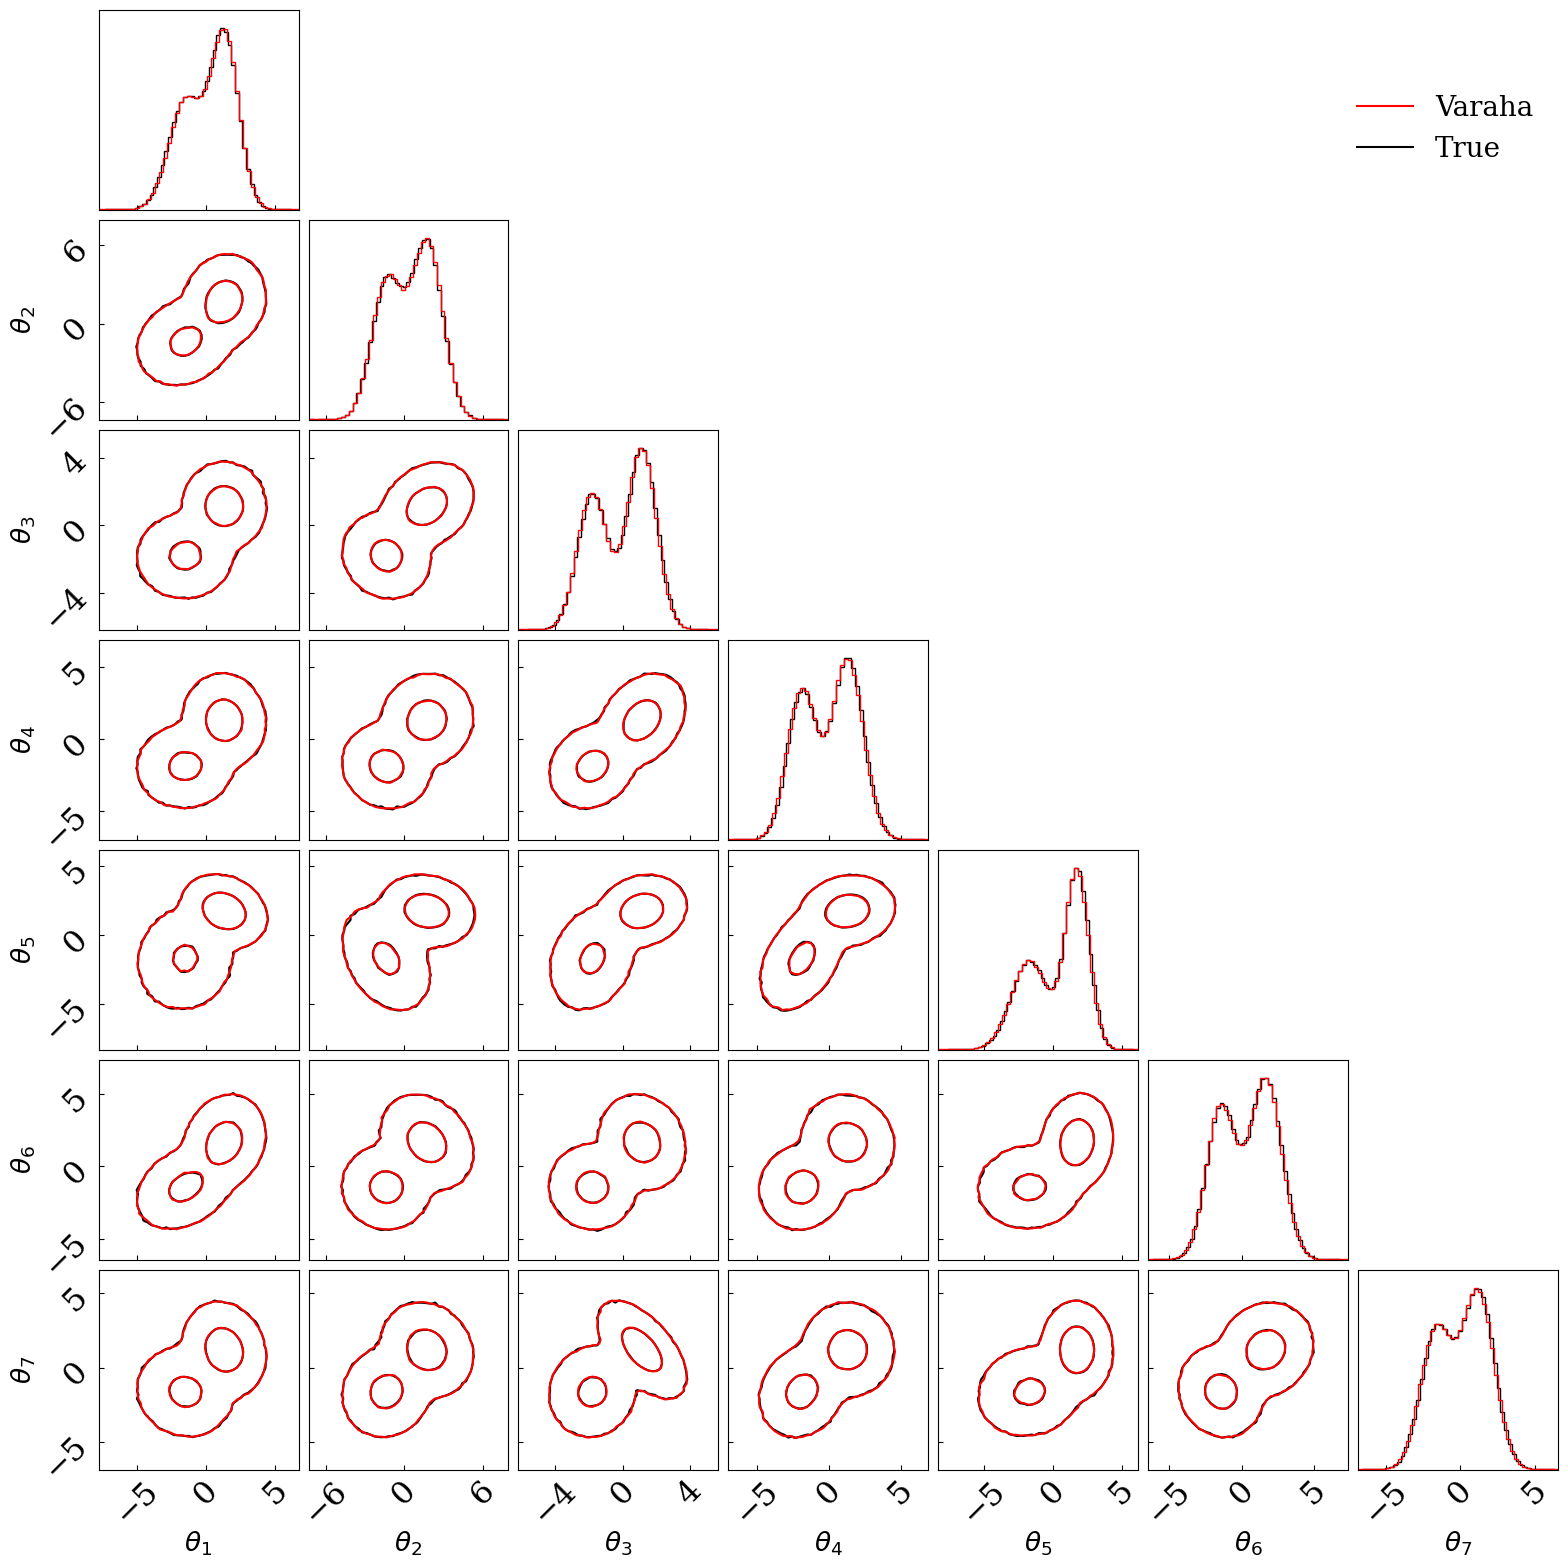

In [6]:
idx = np.where(w > 0.0001)

l=[]
for ii in range(ndim):
    l.append(r'$\theta_{' + str(ii+1) + '}$')
hh = dict(density=True, color = 'black')
figure = corner.corner(true, bins = 50, levels=(0.5, 0.99), plot_density=False, 
                       plot_datapoints=False, color = 'black',labels=l, hist_kwargs=hh, max_n_ticks=5)
hh = dict(density=True, color = 'red')
corner.corner(allx[idx], fig=figure, color='red', bins = 50, levels=(0.5, 0.99), 
              plot_density=False, plot_datapoints=False, weights=w[idx], hist_kwargs=hh, max_n_ticks=3)
plt.legend(handles=[mlines.Line2D([], [], color='red', label='Varaha'), 
                    mlines.Line2D([], [], color='black', label='True')], fontsize=20, frameon=False, 
           bbox_to_anchor=(1, ndim), loc="upper right")
plt.savefig('files/bimodal_gaussian.jpg', dpi = 200., bbox_inches  = 'tight')